Dataset:

https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset/download

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from imblearn.over_sampling import SMOTE
import xgboost

Now let’s read the data and do some exploratory data analysis to understand this dataset properly:

In [2]:
attrition = pd.read_csv('Employee-Attrition.csv')
attrition.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Usually one of the first steps in data exploration is getting a rough idea of how the features are distributed among them. To do this, I’ll use the kdeplot function in the seaborn library

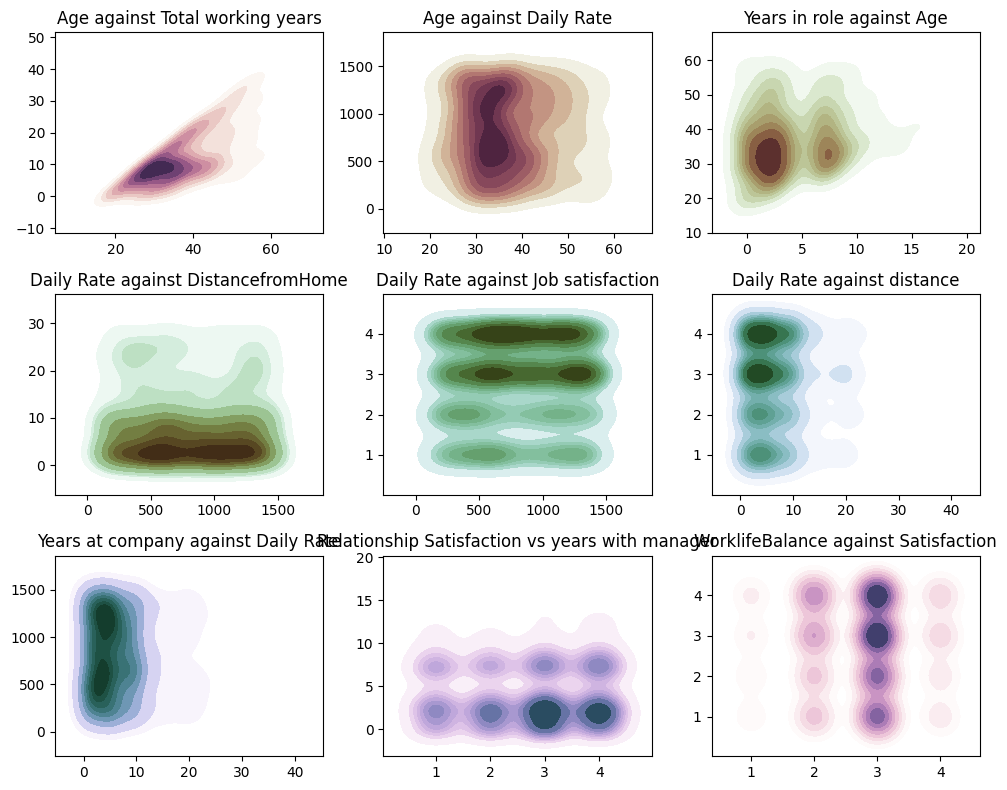

In [3]:
f, axes = plt.subplots(3, 3, figsize=(10, 8),
                        sharex=False, sharey=False)

# Defining our colormap scheme
s = np.linspace(0, 3, 10)
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)

# Genereate and plot
x = attrition['Age'].values
y = attrition['TotalWorkingYears'].values
sns.kdeplot(x=x,y=y, cmap=cmap, fill=True, cut=5, ax=axes[0,0])
axes[0,0].set(title='Age against Total working years')

cmap = sns.cubehelix_palette(start=0.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['Age'].values
y = attrition['DailyRate'].values
sns.kdeplot(x=x, y=y, cmap=cmap, fill=True, ax=axes[0,1])
axes[0,1].set(title='Age against Daily Rate')

cmap = sns.cubehelix_palette(start=0.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsInCurrentRole'].values
y = attrition['Age'].values
sns.kdeplot(x=x, y=y, cmap=cmap, fill=True, ax=axes[0,2])
axes[0,2].set(title='Years in role against Age')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['DistanceFromHome'].values
sns.kdeplot(x=x,y=y, cmap=cmap, fill=True, ax=axes[1,0])
axes[1,0].set(title='Daily Rate against DistancefromHome')

cmap = sns.cubehelix_palette(start=1.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x, y=y, cmap=cmap, fill=True,  ax=axes[1,1])
axes[1,1].set( title = 'Daily Rate against Job satisfaction')

cmap = sns.cubehelix_palette(start=1.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x, y=y, cmap=cmap, fill=True,  ax=axes[1,2])
axes[1,2].set( title = 'Daily Rate against distance')

cmap = sns.cubehelix_palette(start=2.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['DailyRate'].values
sns.kdeplot(x=x, y=y, cmap=cmap, fill=True,  ax=axes[2,0])
axes[2,0].set( title = 'Years at company against Daily Rate')

cmap = sns.cubehelix_palette(start=2.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['RelationshipSatisfaction'].values
y = attrition['YearsWithCurrManager'].values
sns.kdeplot(x=x, y=y, cmap=cmap, fill=True,  ax=axes[2,1])
axes[2,1].set( title = 'Relationship Satisfaction vs years with manager')

cmap = sns.cubehelix_palette(start=2.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['WorkLifeBalance'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x, y=y, cmap=cmap, fill=True,  ax=axes[2,2])
axes[2,2].set( title = 'WorklifeBalance against Satisfaction')

f.tight_layout()

### Finding Correlation

The next step in a data exploration is to find the correlation matrix. By plotting a correlation matrix, we get a really good look at how the features relate to each other. 

In this correlation plot, I will be using the Plotly library in Python to produce an interactive Pearson correlation matrix via the Heatmap function as follows:

In [4]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
attrition["Attrition_numerical"] = attrition["Attrition"].apply(lambda x: target_map[x])

# Creating a list of only numerical values
numerical = [u'Age',u'DailyRate',u'DistanceFromHome',
             u'HourlyRate',u'JobInvolvement',u'JobLevel',u'JobSatisfaction',
             u'MonthlyIncome',u'MonthlyRate',u'NumCompaniesWorked',
             u'PercentSalaryHike',u'PerformanceRating',u'RelationshipSatisfaction',
             u'StockOptionLevel',u'TotalWorkingYears',
             u'TrainingTimesLastYear',u'WorkLifeBalance',u'YearsAtCompany',
             u'YearsInCurrentRole',u'YearsSinceLastPromotion',u'YearsWithCurrManager']
data = [
    go.Heatmap(
        z=attrition[numerical].astype(float).corr().values,   # Generating the Pearson correlation
        x=attrition[numerical].columns.values,
        y=attrition[numerical].columns.values,
        colorscale='Viridis',
        reversescale=False,
        opacity=1.0
    )
]

layout = go.Layout(
    title='Pearson Correlation of numerical features',
    xaxis=dict(ticks='',nticks=36),
    yaxis=dict(ticks=''),
    width=900, height=700,
)

fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='labelled-heatmap')

### Observations From Above Plot:

From the correlation plot, we can see that a lot of our columns appear to be poorly correlated to each other. Generally, when building a predictive model, it would be better to train a model with features that are not too correlated with each other so that we don’t need to deal with redundant features. 

In the case where we have a large number of correlated characteristics, perhaps we could apply a technique such as principal component analysis (PCA) to reduce the characteristic space.

### Feature Engineering

After exploring our dataset, let’s now move on to the task o feature engineering and numerically encoding the categorical values in our dataset. Feature engineering involves creating new features and relationships from the current features that we have.

For this task, we’ll separate the numeric columns from the categorical columns as follows:

In [5]:
attrition = attrition.drop(['Attrition_numerical'], axis=1)

# Empty list to store columns with categorical data
categorical = []
for col, value in attrition.items():
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = attrition.columns.difference(categorical)

After identifying which of our features contain categorical data, we can start to digitally encode the data. To do this, I’ll use Pandas’ get_dummies method in Python which creates dummy variables encoded from the categorical variables:

In [6]:
attrition_cat = attrition[categorical]
attrition_cat = attrition_cat.drop(['Attrition'], axis=1)  # Dropping the target column
attrition_cat = pd.get_dummies(attrition_cat)
attrition_cat.head(3)
attrition_num = attrition[numerical]
attrition_final = pd.concat([attrition_num, attrition_cat], axis=1)

One last step we need to remember is to generate our target variable. The target, in this case, is given by the Attrition column which contains categorical variables therefore requires numeric coding. We digitally encode it by creating a dictionary with the given mapping as 1: Yes and 0: No:

In [7]:
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = attrition["Attrition"].apply(lambda x: target_map[x])

### Machine Learning for Employee Attrition Prediction

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Split data into train and test sets as well as for validation and testing
train, test, target_train, target_val = train_test_split(attrition_final,
                                                         target,
                                                         train_size=0.80,
                                                         random_state=0);

In [9]:
oversampler = SMOTE(random_state=0)
smote_train, smote_target = oversampler.fit_resample(train,target_train)

seed = 0   # We set our random seed to zero for reproducibility
# Random Forest Parameters
rf_params = {
    'n_jobs':-1,
    'n_estimators':1000,
    'max_features':0.3,
    'max_depth':4,
    'min_samples_leaf':2,
    'max_features':'sqrt',
    'random_state':seed,
    'verbose':0
}

rf = RandomForestClassifier(**rf_params)
rf.fit(smote_train,smote_target)
rf_predictions = rf.predict(test)
print("Accuracy score: {}".format(accuracy_score(target_val, rf_predictions)))
print("="*80)
print(classification_report(target_val, rf_predictions))

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Accuracy score: 0.8537414965986394
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       245
           1       0.57      0.49      0.53        49

    accuracy                           0.85       294
   macro avg       0.74      0.71      0.72       294
weighted avg       0.85      0.85      0.85       294



/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/ali/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning

As observed, our Random Forest returns around 88% accuracy for its predictions and at first glance, this may seem like a fairly good model.

Sklearn’s Random Forest classifier also contains a very handy attribute for analyzing feature importance which tells us which features in our dataset have received the most importance by the Random Forest algorithm. Let’s visualize the features taken into account:

In [14]:
trace = go.Scatter(
    y = rf.feature_importances_,
    x = attrition_final.columns.values,
    mode='lines+markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
        colorscale = 'Portland',
        showscale = True
    ),
    text = attrition_final.columns.values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest',
    xaxis=dict(
        ticklen = 5,
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title='Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2023')

Source:

https://thecleverprogrammer.com/2020/11/21/employee-attrition-prediction-with-python/